# Example adapted from:

https://github.com/vrx-/notebooks/blob/master/xgcm/xgcm_roms.ipynb

#########################

In [8]:
import xarray as xr
import numpy as np

#import xroms
from xgcm import Grid

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
#########################

def adjust_coords(ds):

    if 'nav_lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        

    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])


    return ds

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    

        
        
        

In [14]:
%%time

simulname = 'gigatl3'
simulname = 'pacbig'
simulname = 'gigatl1'

#######################

if 'gigatl1' in simulname:
    # Gigatl1
    grdfile = '/net/libra/local/tmp/1/gula/ROMS/Simulations/GIGATL/GIGATL1/gigatl1_grd_masked.nc'
    hisfile = '/net/omega/local/tmp/1/gula/GIGATL1/GIGATL1_1h_tides/SURF/gigatl1_surf.2008-05-23.nc'
    timename='time'
elif 'gigatl3' in simulname:
    # Gigatl3
    grdfile = '/net/libra/local/tmp/1//gula/ROMS/Simulations/GIGATL/GIGATL3/gigatl3_grd.nc'
    hisfile = '/net/omega/local/tmp/1/gula/GIGATL3/GIGATL3_1h_tides/SURF/GIGATL3_1h_inst_surf_2008-05-23-2008-05-27.nc'
    timename='time_counter'
elif 'pacbig' in simulname:
    # Pacbig
    grdfile='/net/krypton/data0/project/meddle/gula/ROMS/Simulations/PACBIG/pacbig_grd_nw_dig.nc'
    hisfile='/net/krypton/data0/project/meddle/gula/ROMS/Simulations/PACBIG/HIS/pacbig_his.0402.nc'
    timename='time'

#######################
# open dqataset
ds = xr.open_dataset(hisfile,chunks={timename:1})

# open grid file
grd = xr.open_dataset(grdfile)

# add grid variables to dataset
# ds.update(grd)
########

# set coords 
ds = adjust_coords(ds)
grd = adjust_coords(grd)

ds = add_grd(ds,grd)

#######################
# Create xgcm grid

grid = ds.attrs['xgcm-Grid']

ds

CPU times: user 16.6 s, sys: 11.7 s, total: 28.3 s
Wall time: 28.3 s


<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 14002, eta_v: 14001, one: 1, time: 120, xi_rho: 10502, xi_u: 10501)
Coordinates:
  * time        (time) float32 927507500.0 927511200.0 927514750.0 ... 0.0 0.0
    lon_rho     (eta_rho, xi_rho) float64 ...
    lat_rho     (eta_rho, xi_rho) float64 ...
    lat_psi     (eta_v, xi_u) float64 -53.59 -53.59 -53.59 ... 65.44 65.44 65.43
    lon_psi     (eta_v, xi_u) float64 -73.24 -73.23 -73.22 ... 27.05 27.06 27.07
Dimensions without coordinates: auxil, eta_rho, eta_v, one, xi_rho, xi_u
Data variables:
    time_step   (time, auxil) int32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    scrum_time  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    temp        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 14002, 10502), meta=np.ndarray>
    salt        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 14002, 10502), meta=np.ndarray>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 14002, 10502), meta=np.ndarray>
    u           (time, eta_rho, xi_u) float32 dask.array<chunksize=(1, 14002, 10501), meta=np.ndarray>
    v           (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 14001, 10502), meta=np.ndarray>
    spherical   (one) |S1 ...
    angle       (eta_rho, xi_rho) float64 ...
    h           (eta_rho, xi_rho) float64 ...
    hraw        (eta_rho, xi_rho) float64 ...
    f           (eta_rho, xi_rho) float64 ...
    pm          (eta_rho, xi_rho) float64 ...
    pn          (eta_rho, xi_rho) float64 ...
    mask_rho    (eta_rho, xi_rho) float64 nan nan nan nan ... nan nan nan nan
    xl          (one) float64 ...
    el          (one) float64 ...
Attributes:
    partition_ucla:  [    0  6582   422     1 10500 14000]
    title:           GIGATL1
    date:            
    rst_file:        RST/gigatl1_r74_rst.0004.nc
    his_file:        HIS/gigatl1_his.000000.0004.nc
    avg_file:        AVG/gigatl1_avg.0004.nc
    grd_file:        ./INIT/GRD3/gigatl1_grd_masked.0004.nc
    ini_file:        RST/gigatl1_r73_rst.0004.nc
    frc_file:        ./INIT/FRC/gigatl1_frc_clim.0004.nc
    qbar_file:       ./INIT/gigatl1_runoff.nc
    VertCoordType:   NEW
    theta_s:         5.0
    theta_s_expl:    S-coordinate surface control parameter
    theta_b:         2.0
    theta_b_expl:    S-coordinate bottom control parameter
    Tcline:          300.0
    Tcline_expl:     S-coordinate surface/bottom layer width
    Tcline_units:    meter
    hc:              300.0
    hc_expl:         S-coordinate parameter, critical depth
    hc_units:        meter
    sc_w:            [-1.   -0.99 -0.98 -0.97 -0.96 -0.95 -0.94 -0.93 -0.92 -...
    sc_w_expl:       S-coordinate at W-points
    Cs_w:            [-1.0000000e+00 -9.8373526e-01 -9.6669787e-01 -9.4893485...
    Cs_w_expl:       S-coordinate stretching curves at W-points
    sc_r:            [-0.995 -0.985 -0.975 -0.965 -0.955 -0.945 -0.935 -0.925...
    sc_r_expl:       S-coordinate at W-points
    Cs_r:            [-9.91966903e-01 -9.75310326e-01 -9.57903922e-01 -9.3979...
    Cs_r_expl:       S-coordinate stretching curves at RHO-points
    ntimes:          1425610
    ndtfast:         20
    dt:              20.0
    dtfast:          1.0
    nwrt:            180
    ntsavg:          1
    ntsavg_expl:     starting time-step for accumulation of time-averaged fields
    navg:            21600
    navg_expl:       number of time-steps between time-averaged records
    tnu4:            0.0
    tnu4_expl:       biharmonic mixing coefficient for tracers
    units:           meter4 second-1
    Akv_bak:         0.0
    Akv_bak_expl:    background vertical mixing coefficient for momentum
    Akv_bak_units:   meter2 second-1
    Akt_bak:         [0. 0.]
    Akt_bak_expl:    background vertical mixing coefficient for tracers
    Akt_bak_units:   meter2 second-1
    Zob:             0.01
    Zob_expl:        VonKarman/Prandtl log layer : roughness scale
    Zob_units:       meter
    Cdb_max:   

In [15]:
# Turn on chunking to activate dask and parallelize read/write.

ds = ds.chunk({'xi_rho': 1000,'eta_rho': 1000 })

In [16]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46729")
client

/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/distributed/client.py:1129: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| numpy   | 1.19.2 | 1.18.4    | 1.18.4  |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://127.0.0.1:46729 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 67.55 GB


# Compute vorticity

In [17]:
%%time

ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'eta'),  'xi') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'xi'),  'eta') # at psi points (eta_v, xi_u)
ds['dudy'] = grid.diff(ds.u, 'eta')*ds['pn_psi']
ds['dvdx'] = grid.diff(ds.v, 'xi')*ds['pm_psi']
ds['f_psi'] = grid.interp(grid.interp(ds.f, 'eta'),  'xi')
ds['mask_psi'] = grid.interp(grid.interp(ds.mask_rho, 'eta'),  'xi') # at psi points (eta_v, xi_u) 


ds['vor'] = ds['dvdx'] - ds['dudy']
ds['rvor'] = ds.vor/ds['f_psi']*ds['mask_psi'] # normalized vorticity
ds['rvor']

/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/dask/array/core.py:4048: PerformanceWarning: Increasing number of chunks by factor of 21
  **blockwise_kwargs,
/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/dask/array/core.py:4048: PerformanceWarning: Increasing number of chunks by factor of 29
  **blockwise_kwargs,


CPU times: user 2.28 s, sys: 50.5 ms, total: 2.33 s
Wall time: 2.35 s


<xarray.DataArray 'rvor' (time: 120, eta_v: 14001, xi_u: 10501)>
dask.array<mul, shape=(120, 14001, 10501), dtype=float64, chunksize=(1, 999, 999), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float32 927507500.0 927511200.0 927514750.0 ... 0.0 0.0 0.0
    lat_psi  (eta_v, xi_u) float64 dask.array<chunksize=(14001, 10501), meta=np.ndarray>
    lon_psi  (eta_v, xi_u) float64 dask.array<chunksize=(14001, 10501), meta=np.ndarray>
Dimensions without coordinates: eta_v, xi_u

# Plot vrt

CPU times: user 22.5 s, sys: 12.6 s, total: 35.1 s
Wall time: 1min 7s


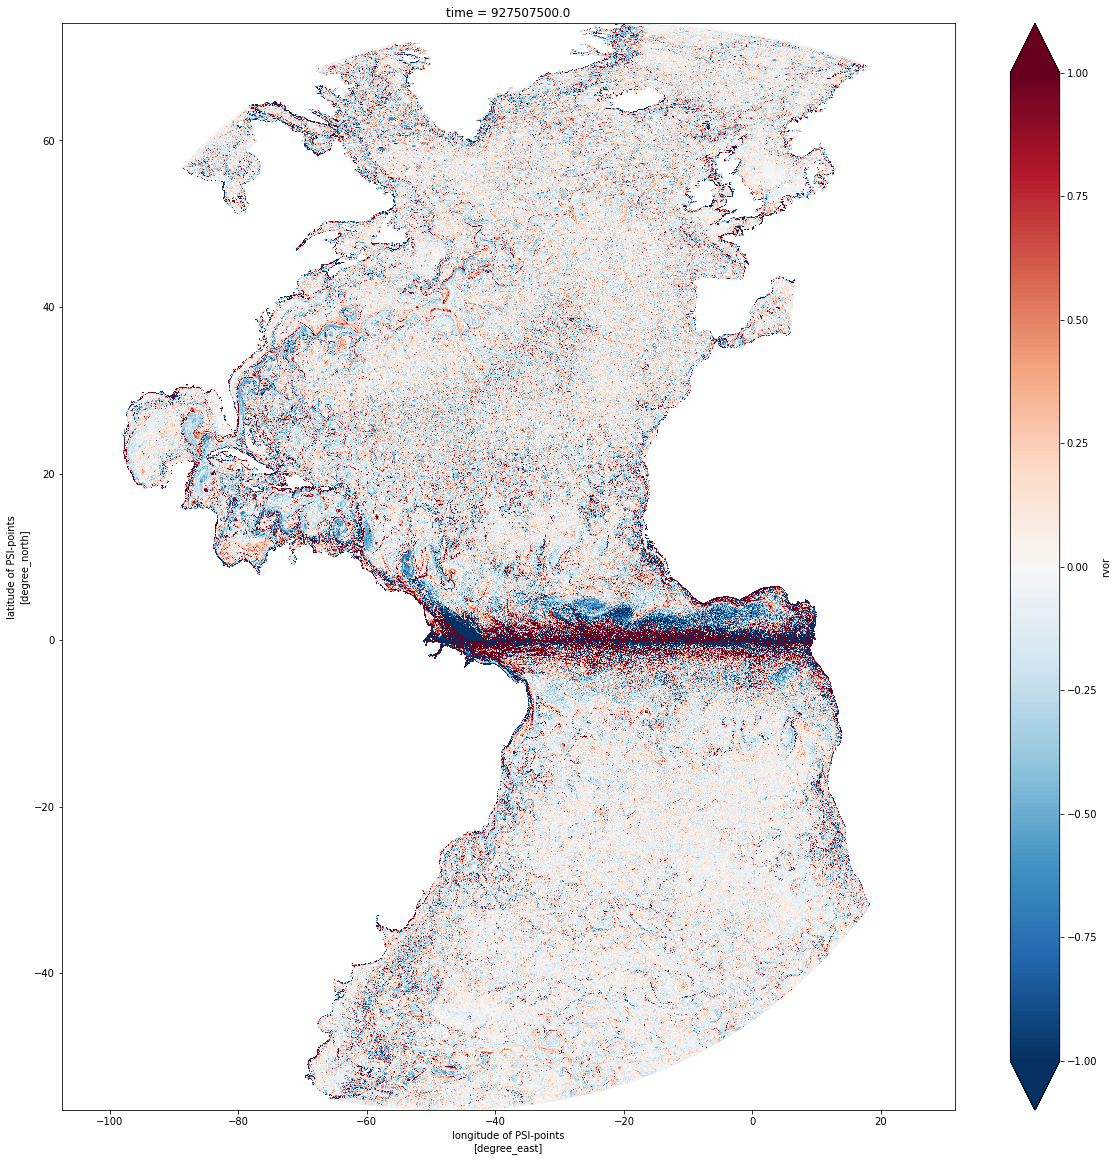

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [18]:
%%time

        
fig = plt.figure(figsize=(20,20))

ds.rvor.isel(time=0).plot(x='lon_psi', y='lat_psi',
                               vmin=-1., vmax=1., cmap='RdBu_r')

#####


In [56]:
#ds.rvor.data.visualize()